# Application for analyzing COUNTER usage data, cost information, and other journal quality metrics

The following application allows a user to input a number of CSV files containing standardized (through release 4) COUNTER data to be analyzed for full-text retrievals as a measure of journal use. It then performs various calculations and a high-level overview of the data. It also compares cost information, and utilizes the Scopus API (key required) to gather journal metrics for comparison with local usage data.

# Data collection and cleaning

In [1]:
from pathlib import Path
import re

class UI:
    '''Utility class for displaying messages to application user and collecting files to be analyzed'''
    
    def __init__(self):
        self.printIntro()
    
    @classmethod
    def printIntro(self):
        print("This application is designed to ingest one or more COUNTER-compliant CSV files for analysis.")
        print("It starts by asking for a list of file names to work with, then conduct a series of analyses.\n")
    
    @classmethod
    def getFiles(self):
        '''Method to get file names to use for analysis. Checks if files exist before saving to list.'''
        file = ""
        files = []
        file_num = 1 # counter for showing user number of files entered

        while file != "-1":
            print("Please enter the filename(s) you would like to work with. Enter -1 when you are finished.\n")
            file = input(f"File #{file_num}: ")
            if file != "-1" and file not in files:
                file_path = Path(file)
                if file_path.is_file(): # make sure file exists before proceeding
                    files.append(file)
                    file_num += 1
                else:
                    print("This file does not exist, please enter a valid file name.")
        files.sort() # sort list to put into chronological order
        return files
    
    @classmethod
    def years_from_files(self, list):
        '''Method to deduce year range of data input based on supplied file names'''        
        year_list = []
        for name in list:
            year = re.sub(r"[^0-9]", "", name) # remove all chars except #s
            year_list.append(year)
        print("The years of data to be analyzed are: ")
        for yr in year_list:
            print(yr)
        return year_list        


In [2]:
UI.printIntro()
user_files = UI.getFiles() # get files to be analyzed from user
file_years = UI.years_from_files(user_files)

This application is designed to ingest one or more COUNTER-compliant CSV files for analysis.
It starts by asking for a list of file names to work with, then conduct a series of analyses.

Please enter the filename(s) you would like to work with. Enter -1 when you are finished.

File #1: BMJ_2013.csv
This file does not exist, please enter a valid file name.
Please enter the filename(s) you would like to work with. Enter -1 when you are finished.

File #1: BMJ_2014.csv
Please enter the filename(s) you would like to work with. Enter -1 when you are finished.

File #2: BMJ_2018.csv
Please enter the filename(s) you would like to work with. Enter -1 when you are finished.

File #3: BMJ_2015.csv
Please enter the filename(s) you would like to work with. Enter -1 when you are finished.

File #4: BMJ_2016.csv
Please enter the filename(s) you would like to work with. Enter -1 when you are finished.

File #5: BMJ_2017.csv
Please enter the filename(s) you would like to work with. Enter -1 when you 

In [3]:
import pandas as pd

class CleanReader:
    '''Class for reading csv files and cleaning them up for analysis'''
    
    def __init__(self, raw_list):
        self.clean_list = [] # list to be populated with cleaned files
        self.clean(raw_list)
        
    def clean(self, raw_list):
        '''Method to take a list of files and send them to rmv_header() to return list of cleaned files'''
        for raw_file in raw_list:
            clean_file = self.rmv_header(raw_file)
            self.clean_list.append(clean_file)
        return self.clean_list
    
    def rmv_header(self, filename):
        '''Method to remove extraneous header rows from file. Identifies start of data and converts columns to proper data types.'''
        try:
            raw_df = pd.read_csv(filename)
            col1 = raw_df.iloc[:, 0] # get first column as series to locate index of header Journal
            header_index = col1[col1 == "Journal"].index[0] # get index value where column headers begin, at Col A = "Journal"
            df = raw_df.iloc[header_index + 1:] # create new DF where data begins after headers
            column_labels = raw_df.iloc[header_index]
            df.columns = column_labels # set columns to proper column labels
            df[column_labels[7:22]] = df[column_labels[7:22]].apply(pd.to_numeric) # convert columns to proper datatypes
            if set(["Cost","Fee", "Total"]).issubset(df.columns): # check if these non-standard columns exist
                df["Cost"] = df["Cost"].astype(float)
                df["Fee"] = df["Fee"].astype(float)
                df["Total"] = df["Total"].astype(float)
        except FileNotFoundException: # In the event that no file is found
            print("rmv_header: File not found.")
        return df

In [4]:
clean_files = CleanReader(user_files).clean_list # get cleaned version of data to use for analysis

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:2440: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/sta

In [5]:
from functools import reduce
import math

class DataFramer:
    '''Class for obtaining slices and portions of dataframe or merging dataframes for analysis'''
    
    def __init__(self, frame_list):
        '''Init makes a deep copy of dataframes passed in list for targeted pulling and merging of data'''
        self.init_frames = []
        for frame in frame_list:
            self.init_frames.append(frame.copy())
        
        # store master list of ISSNs associated with frames for API searching
        for frame in frame_list:
            ids = frame["Online ISSN"]
            prelim_issn = []
            for id in ids:
                if id not in prelim_issn: # make sure ISSN is unique
                    prelim_issn.append(id)
            self.issn = [i for i in prelim_issn if str(i) != 'nan'] # remove empty NaN values
            
    def get_months(self):
        '''Method accepts list of files and returns list of dataframes for monthly journal usage counts'''
        month_counts = []
        for frame in self.init_frames:
            month_df = frame.iloc[:,[0,10,11,12,13,14,15,16,17,18,19,20,21]] # grab the column for journal title and monthly stats
            month_counts.append(month_df)
        return month_counts

    def get_total_counts(self):
        '''Method accepts list of files and returns list of dataframes for total journal usage counts'''
        total_counts = []
        for frame in self.init_frames:
            counts = frame.iloc[:,[0,7]] # grab the column for journal title and total usage counts
            total_counts.append(counts)
        return total_counts

    def get_total_cost(self):
        '''Method accepts list of files and returns list of dataframes for total cost info for all journals'''
        total_cost = []
        for frame in self.init_frames:
            costs = frame.iloc[:,[0,-1]]
            total_cost.append(costs)
        return total_cost
    
    def get_issns(self):
        '''Method accepts a list of files and returns a list of dataframes for ISSNs with journal titles'''
        issn_list = []
        for frame in self.init_frames:
                issn = frame.iloc[1:,[0,6]]
                issn_list.append(issn)
        return issn_list

    def merge_df(self, data_list, column_name):
        '''Method accepts list of dataframes with shared journal name and merges data'''
        # use outer join to retain values in event that rows don't match so nothing is lost
        merge_df = reduce(lambda left, right: pd.merge(left, right, on=column_name, how="outer"), data_list).set_index("Journal")
        return merge_df
    
    def comb_df(self, df):
        '''Method accepts a dataframe with a specified column and returns just that specified column'''
        column = df["Comb. Total"]
        return column


In [6]:
framer = DataFramer(clean_files) # create a DataFramer object to extract different portions of the data
month_counts = framer.get_months() # create new list of DFs for monthly usage counts from cleaned file
total_counts = framer.get_total_counts() # create new list of DFs for total usage counts from cleaned file
total_cost = framer.get_total_cost() # create new list of DFs for total cost info from cleaned file
issn_ids = framer.get_issns() # create new list of DFs for ISSNs and journal title

month_concat = framer.merge_df(month_counts, "Journal") # combine all data into one DF of monthly usage counts for processing
month_concat.head(20)

,Jan-14,Feb-14,Mar-14,Apr-14,May-14,Jun-14,Jul-14,Aug-14,Sep-14,Oct-14,...,18-Mar,18-Apr,18-May,18-Jun,18-Jul,18-Aug,18-Sep,18-Oct,18-Nov,18-Dec
Journal,,,,,,,,,,,,,,,,,,,,,
Total for all journals,1854,2126,2067,1994,1948,1950,1877,1702,1657,1288,...,2272,1989,2450,2097,2080,2079,1983,2656,2306,1877
Annals of the Rheumatic Diseases,176,176,220,222,185,148,149,172,169,161,...,213,204,185,182,130,140,175,252,178,255
Archives of Disease in Childhood,161,146,158,117,106,111,154,164,195,109,...,126,101,122,119,114,120,106,201,165,68
BMJ,667,860,702,623,705,712,561,485,375,163,...,660,535,706,548,673,509,458,871,653,698
BMJ Case Reports,0,0,0,0,0,0,0,0,0,0,...,77,79,106,108,96,76,92,88,147,71
BMJ Quality & Safety,54,100,59,124,80,84,71,88,66,65,...,92,120,158,132,107,204,81,117,129,89
British Journal of Ophthalmology,74,73,49,45,69,67,67,78,76,58,...,66,54,75,55,82,89,90,76,96,65
British Journal of Sports Medicine,108,128,185,124,124,120,106,83,102,75,...,221,138,220,167,170,237,326,288,195,152
Gut,142,126,111,148,124,133,111,141,160,121,...,152,141,184,172,155,140,131,156,194,86


In [7]:
# create master dataframe of ISSNs from all files to be used for API calls
issn_all = reduce(lambda left,right: pd.merge(left,right, how = "left", left_on=['Online ISSN', 'Journal'], right_on=['Online ISSN', 'Journal']), issn_ids)
issn_all.head(20)

,Journal,Online ISSN
0,Annals of the Rheumatic Diseases,1468-2060
1,Archives of Disease in Childhood,1468-2044
2,BMJ,1756-1833
3,BMJ Case Reports,1757-790X
4,BMJ Quality & Safety,2044-5423
5,British Journal of Ophthalmology,1468-2079
6,British Journal of Sports Medicine,1473-0480
7,Gut,1468-3288
8,Heart,1468-201X
9,Journal of Clinical Pathology,1472-4146


In [8]:
count_concat = framer.merge_df(total_counts, "Journal") # combine all data into one DF of total usage counts for processing
count_concat.columns = file_years # update column labels for readability
count_concat.head(20)

,2014,2015,2016,2017,2018
Journal,,,,,
Total for all journals,20908,20684,21950,26414,26472
Annals of the Rheumatic Diseases,1999,1798,1798,2157,2286
Archives of Disease in Childhood,1674,1766,1292,1205,1468
BMJ,6516,6148,6997,8152,7687
BMJ Case Reports,0,0,403,1026,1110
BMJ Quality & Safety,891,883,1023,1369,1508
British Journal of Ophthalmology,750,620,767,895,897
British Journal of Sports Medicine,1364,1525,1997,2305,2532
Gut,1471,1375,1586,1611,1810


In [9]:
cost_concat = framer.merge_df(total_cost, "Journal") # combine all data into one DF of total cost for processing
cost_concat.columns = file_years # update column labels for readability
cost_concat.head(20)

,2014,2015,2016,2017,2018
Journal,,,,,
Total for all journals,23900.0,26490.77,49380.79,54046.59,56435.04
Annals of the Rheumatic Diseases,2110.0,2411.27,4182.10,4391.78,4699.03
Archives of Disease in Childhood,2067.0,2364.56,4101.14,4306.66,4608.72
BMJ,3031.0,3391.15,5412.13,5684.09,6082.68
BMJ Case Reports,0.0,0.00,1579.84,2537.91,2715.41
BMJ Quality & Safety,1523.0,1753.18,3042.38,3196.00,3419.17
British Journal of Ophthalmology,1570.0,1793.66,3110.89,4571.35,3494.95
British Journal of Sports Medicine,1746.0,1991.92,3454.46,3627.81,3882.12
Gut,2023.0,2265.95,3930.91,4128.13,4417.73


In [13]:
import urllib.request
import json

class ScopusAPI:
    '''Class for importing journal metrics from Scopus based on journal ISSN'''
    '''REQUIRES API KEY, WHICH WAS REMOVED BEFORE ASSIGNMENT SUBMISSION, BUT WAS TESTED WITH KEY'''
    
    @classmethod
    def getSnips(self, list):
        '''Method to call Scopus API and retrieve JSON data to return SNIP rating associated with journal ISSNs'''
        snips = []
        for issn in list:
            with urllib.request.urlopen(f"https://api.elsevier.com/content/serial/title?issn={issn}&field=SNIP&view=STANDARD&apiKey={KEY_PLACEHOLDER}") as url:
                data = json.loads(url.read().decode())
                dict = data['serial-metadata-response']['entry'][0]["SNIPList"]["SNIP"][0] # navigate to part of JSON record with SNIP value
                snip = float(dict["$"]) # convert SNIP to float type
                snips.append(snip)
        return snips

In [14]:
snips = ScopusAPI.getSnips(framer.issn) # use journal issns to call Scopus API and obtain SNIP data
zipped_issn = list(zip(framer.issn, snips)) # combine ISSNs with SNIP values

issn_df = pd.DataFrame(zipped_issn, columns = ['Online ISSN', 'SNIP']) # create dataframe of ISSN + SNIP rating
issn_SNIP_df = framer.merge_df([issn_all,issn_df],"Online ISSN") # merge this DF with overall ISSN DF from all files to match with title
issn_SNIP_df.head(20)

,Online ISSN,SNIP
Journal,,
Annals of the Rheumatic Diseases,1468-2060,3.594
Archives of Disease in Childhood,1468-2044,1.504
BMJ,1756-1833,3.650
BMJ Case Reports,1757-790X,0.305
BMJ Quality & Safety,2044-5423,2.726
British Journal of Ophthalmology,1468-2079,1.495
British Journal of Sports Medicine,1473-0480,3.401
Gut,1468-3288,3.855
Heart,1468-201X,1.669


In [15]:
import numpy as np

class Calculator:
    '''Utility class for performing basic calculations on data'''
    
    @classmethod
    def pct_change(self, data):
        '''Method to calculate the % change for column values from left to right'''
        change = data.pct_change(axis = 1)
        return change
    
    @classmethod
    def sum_rows(self, df):
        '''Method accepts a dataframe and returns a dataframe with the sum of its rows'''
        df.loc[:,"Comb. Total"] = df.sum(axis = 1)
        return df
    
    @classmethod
    def cpu(self, cost, count):
        '''Method to return the cost per use when given cost and usage counts'''
        cpu = cost / count
        return cpu

# Time to do some calculations

In [16]:
count_change = Calculator.pct_change(count_concat) # get percent change in usage year to year
print("The following shows the percent increase (or decrease) in usage after the initial year of data, year by year")
count_change

The following shows the percent increase (or decrease) in usage after the initial year of data, year by year


,2014,2015,2016,2017,2018
Journal,,,,,
Total for all journals,NaN,-0.010714,0.061207,0.203371,0.002196
Annals of the Rheumatic Diseases,NaN,-0.100550,0.000000,0.199666,0.059805
Archives of Disease in Childhood,NaN,0.054958,-0.268403,-0.067337,0.218257
BMJ,NaN,-0.056476,0.138094,0.165071,-0.057041
BMJ Case Reports,NaN,NaN,inf,1.545906,0.081871
BMJ Quality & Safety,NaN,-0.008979,0.158550,0.338221,0.101534
British Journal of Ophthalmology,NaN,-0.173333,0.237097,0.166884,0.002235
British Journal of Sports Medicine,NaN,0.118035,0.309508,0.154231,0.098482
Gut,NaN,-0.065262,0.153455,0.015763,0.123526


In [12]:
cost_change = Calculator.pct_change(cost_concat) # get the percent change in cost year to year
print("The following shows the percent increase (or decrease) in cost after the initial year of data, year by year.")
cost_change

The following shows the percent increase (or decrease) in cost after the initial year of data, year by year.


,2014,2015,2016,2017,2018
Journal,,,,,
Total for all journals,NaN,0.108400,0.864075,0.094486,0.044192
Annals of the Rheumatic Diseases,NaN,0.142782,0.734397,0.050137,0.069960
Archives of Disease in Childhood,NaN,0.143957,0.734420,0.050113,0.070138
BMJ,NaN,0.118822,0.595957,0.050250,0.070124
BMJ Case Reports,NaN,NaN,inf,0.606435,0.069939
BMJ Quality & Safety,NaN,0.151136,0.735349,0.050493,0.069828
British Journal of Ophthalmology,NaN,0.142459,0.734381,0.469467,-0.235467
British Journal of Sports Medicine,NaN,0.140848,0.734236,0.050182,0.070100
Gut,NaN,0.120094,0.734773,0.050172,0.070153


In [17]:
sum_cost = Calculator.sum_rows(cost_concat) # get df with column for total cost for all journals for all years
comb_cost = framer.comb_df(sum_cost) # get just the combined cost data
print("The following shows the total combined cost in $ for each journal and all journals for the input time period.")
comb_cost

The following shows the total combined cost in $ for each journal and all journals for the input time period.


Journal
Total for all journals                             210253.19
Annals of the Rheumatic Diseases                    17794.18
Archives of Disease in Childhood                    17448.08
BMJ                                                 23601.05
BMJ Case Reports                                     6833.16
BMJ Quality & Safety                                12933.73
British Journal of Ophthalmology                    14540.85
British Journal of Sports Medicine                  14702.31
Gut                                                 16765.72
Heart                                               17728.93
Journal of Clinical Pathology                       16731.72
Journal of Investigative Medicine                    3562.42
Journal of Medical Genetics                         14972.05
Journal of Neurology, Neurosurgery & Psychiatry     18695.22
Thorax                                              13943.77
Name: Comb. Total, dtype: float64

In [18]:
sum_count = Calculator.sum_rows(count_concat) # get df with total usage counts for all journals for all years
comb_count = framer.comb_df(sum_count) # get just the comb usage data
print("The following shows the total combined usage counts for each journal and all journals for the input time period.")
comb_count

The following shows the total combined usage counts for each journal and all journals for the input time period.


Journal
Total for all journals                             116428
Annals of the Rheumatic Diseases                    10038
Archives of Disease in Childhood                     7405
BMJ                                                 35500
BMJ Case Reports                                     2539
BMJ Quality & Safety                                 5674
British Journal of Ophthalmology                     3929
British Journal of Sports Medicine                   9723
Gut                                                  7853
Heart                                                7326
Journal of Clinical Pathology                        2688
Journal of Investigative Medicine                     484
Journal of Medical Genetics                          5229
Journal of Neurology, Neurosurgery & Psychiatry     11390
Thorax                                               6645
Name: Comb. Total, dtype: int64

In [19]:
cpu_all = Calculator.cpu(comb_cost[0], comb_count[0]) # calculate cost per use for whole set of journals combined
print(f"The total cost per use for this set of journal titles is: ${cpu_all:.2f}.")

The total cost per use for this set of journal titles is: $1.81.


In [20]:
cpu_list = Calculator.cpu(comb_cost[1:], comb_count[1:]) # calculate cost per use for all journals
print("The following represents the total cost per use per title over the date range of supplied data.")
cpu_list

The following represents the total cost per use per title over the date range of supplied data.


Journal
Annals of the Rheumatic Diseases                   1.772682
Archives of Disease in Childhood                   2.356257
BMJ                                                0.664818
BMJ Case Reports                                   2.691280
BMJ Quality & Safety                               2.279473
British Journal of Ophthalmology                   3.700904
British Journal of Sports Medicine                 1.512117
Gut                                                2.134945
Heart                                              2.420001
Journal of Clinical Pathology                      6.224598
Journal of Investigative Medicine                  7.360372
Journal of Medical Genetics                        2.863272
Journal of Neurology, Neurosurgery & Psychiatry    1.641371
Thorax                                             2.098385
Name: Comb. Total, dtype: float64

In [21]:
print(f"The average cost per use for these titles is: ${np.mean(cpu_list):.2f}") # Get a basic overview of the data
print(f"The lowest cost per use for these titles is ${np.min(cpu_list):.2f}")
print(f"The highest cost per use for these titles is ${np.max(cpu_list):.2f}")

The average cost per use for these titles is: $2.84
The lowest cost per use for these titles is $0.66
The highest cost per use for these titles is $7.36


In [22]:
# calculate the pearson correlation coefficient to compare whether there's a correlation btwn usage counts and SNIP metric
from scipy.stats.stats import pearsonr

count_array = [] # create array from comb. total counts for each journal
title_array = [] # create list of journal titles for plot labels
i = 1
while i < len(comb_count):
    count_array.append(comb_count[i])
    title_array.append(comb_count.index[i])
    i += 1
print("The following calculation shows the strength of the correlation between the usage counts and SNIP metric.")
print("The first value returned is the r-value. Values between .3-.5 indicate medium correlation, and .5-1.0 are strong.")
pearsonr(count_array,snips)

The following calculation shows the strength of the correlation between the usage counts and SNIP metric.
The first value returned is the r-value. Values between .3-.5 indicate medium correlation, and .5-1.0 are strong.


(0.6067230327337347, 0.02141503844019529)

# Let's plot the data and some of our findings

In [23]:
import matplotlib.pyplot as plt

class Plotter:
    '''Parent class for making line graphs using MatPlotLib'''

    def __init__(self, title, array, x, y):
        self.fig = plt.figure()
        self.fig.suptitle(title) # supply title
        self.array = array
        plt.xlabel(x) # assign x-axis label
        plt.ylabel(y) # assign y-axis label

class SinglePlotter(Plotter):
    '''Child class of Plotter to carry out basic plot of a single array of data'''
    
    def __init__(self, title, array, x, y):
        super().__init__(title, array, x, y)
        
    def plot(self, array=None):
        if array is not None:
            plt.plot(array, marker='o', linestyle="None")
        else:
            plt.plot(self.array)
        
    def xticks(self, xtick_labels, xtick_deg = 30):
        plt.xticks(np.arange(len(self.array)), xtick_labels, rotation=xtick_deg) # configure ticks marks on x-axis

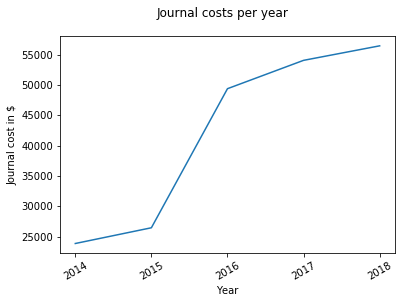

In [24]:
# let's plot the cost of all journal subscriptions by year
jrnl_cost_array = cost_concat.iloc[0, :-1].values # get array of just total cost for all files

plotter1 = SinglePlotter("Journal costs per year", jrnl_cost_array, "Year", "Journal cost in $") # create plotter object
plotter1.plot()
plotter1.xticks(file_years) # add x-axis ticks to chart

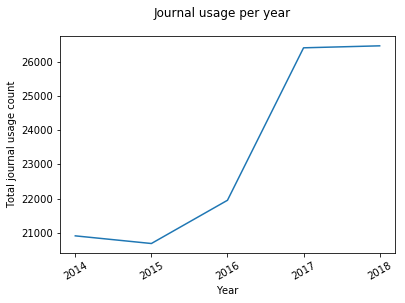

In [25]:
# let's plot the total usage of all journals per year
jrnl_use_array = count_concat.iloc[0, :-1].values # get array of total usage counts, excluding comb. total column

plotter2 = SinglePlotter("Journal usage per year", jrnl_use_array, "Year", "Total journal usage count")
plotter2.plot()
plotter2.xticks(file_years)

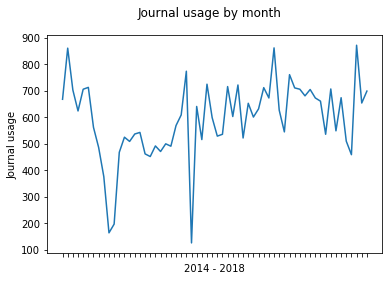

In [26]:
# Let's plot the usage of a journal over the time span given
journal = month_concat.iloc[3].values # get journal to plot
plotter3 = SinglePlotter("Journal usage by month", journal, f"{file_years[0]} - {file_years[-1]}", "Journal usage")
plotter3.plot()
plotter3.xticks([])

In [27]:
from itertools import cycle

class MultiPlotter(Plotter):
    '''Class to do a basic plot of multiple lines using a line cycler to vary line patterns for readability'''
    
    def __init__(self, title, array, x, y, lines, xtick_labels):
        super().__init__(title, array, x, y) # call the parent constructor
        self.lines = lines
        self.xticks = xtick_labels
        
    def plot(self):
        linecycler = cycle(lines) # create linecycler to cycle through line styles
        i = 0
        while i < (len(journal)):
            jrnl_sub = journal[i:i+12] # get the first year's data 
            plt.plot(jrnl_sub,next(linecycler)) # plot year's data
            i = i + 12 # increment loop to next year
        plt.legend(self.xticks)

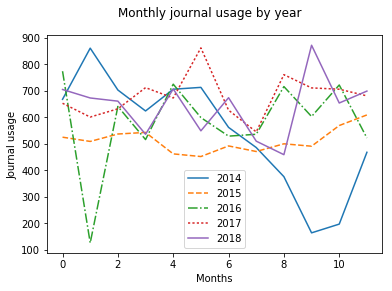

In [28]:
# let's plot the same data as above, but plot each year separately
lines = ["-","--","-.",":"] # create line styles for different years
multi_plotter1 = MultiPlotter("Monthly journal usage by year", journal, "Months", "Journal usage", lines, file_years)
multi_plotter1.plot()

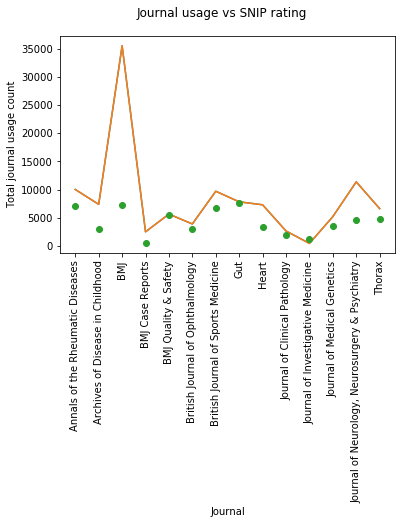

In [29]:
snips_x = [i * 2000 for i in snips] # use multiplier to better visualize SNIP metric vs usage

plotter4 = SinglePlotter("Journal usage vs SNIP rating", count_array, "Journal", "Total journal usage count")
plotter4.plot()
plotter4.plot()
plotter4.xticks(title_array, 90)
plotter4.plot(snips_x)